In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import re

In [3]:
import datetime

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from plotting import *

## Acquisition

In [6]:
experiment_name = 'jian_5K'

### Experiments parameters 

In [43]:
n=4
# g=4

In [29]:
def get_he_se_numbers(experiment_name,n,g,group_batch=True):

    log_file_name = experiment_name+'-n'+str(n)+'-g'+str(g)
    all_lines=load_results(log_file_name)

    all_seconds, all_losses = get_times_losses(all_lines)

    iters =[line[2] for line in all_lines]
    
    if group_batch:
        # Each group is responsible of a mini-batch
        total_batches=g*(np.max(iters)-iters[0])
    else:
        # Each worker is responsible for a mini-batch
        total_batches=n*(np.max(iters)-iters[0])

    total_time = all_seconds[-1]

    seconds_per_batch = total_time/total_batches
    
    return seconds_per_batch, total_batches, total_time



In [174]:
get_he_se_numbers(experiment_name, 4, 1)

(0.124572, 2874, 358.019928)

In [175]:
get_he_se_numbers(experiment_name, 4, 2)

(0.10534054980595084, 18552, 1954.27788)

In [176]:
get_he_se_numbers(experiment_name, 4, 4)

(0.09397341999287241, 11224, 1054.757666)

In [11]:
def get_smoothed_loss(experiment_name,n,g,window=250):

    log_file_name = experiment_name+'-n'+str(n)+'-g'+str(g)
    all_lines=load_results(log_file_name)

    all_seconds, all_losses = get_times_losses(all_lines)
    
    return all_seconds,moving_average(all_losses,window_size=window)

In [21]:
W=800

In [22]:
all_g = [1,2]

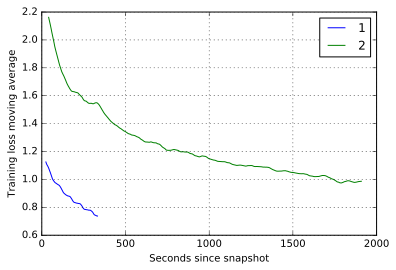

In [23]:
all_seconds_per_batch=[]
all_total_batches=[]
all_total_time=[]
for g in all_g:
    seconds, losses = get_smoothed_loss(experiment_name,4,g,window=W)
    plt.plot(seconds,losses, label=g)

plt.xlabel('Seconds since snapshot')
plt.ylabel('Training loss moving average')
plt.legend()
plt.grid()

### Calculate the target loss: lowest loss achieved by all configurations

In [24]:
all_losses=[]
all_seconds=[]
max_min_loss = -np.inf
for g in all_g:
    seconds, losses = get_smoothed_loss(experiment_name,4,g,window=W)
    all_losses.append(losses)
    all_seconds.append(seconds)
    if np.nanmin(losses)>max_min_loss:
        max_min_loss = np.nanmin(losses)
print max_min_loss

0.974211486189


In [25]:
max_min_loss

0.97421148618906261

### Estimate the time (in seconds) it took each configuration to reach this target loss

In [26]:
assert(not np.isinf(max_min_loss))
all_crossings =[]
for gi in range(len(all_g)):
    g=all_g[gi]
    losses = all_losses[gi]
    crossing_index = np.nonzero(losses[W:-W]<=max_min_loss)[0][0]+W
    crossing_time = seconds[np.nonzero(losses[W:-W]<=max_min_loss)[0][0]+W]
    all_crossings.append(crossing_time)

In [27]:
all_crossings

[135.45068, 1787.301352]

### Calculate how many iterations (batches) were required to reach target loss 

In [30]:
all_seconds_per_batch=[]
all_total_batches=[]
all_total_time=[]
all_batches_to_target=[]
for gi in range(len(all_g)):
    g=all_g[gi]
    spb, tb, tt = get_he_se_numbers(experiment_name,4,g)
    all_seconds_per_batch.append(spb)
    all_total_batches.append(tb)
    all_total_time.append(tt)
    all_batches_to_target.append(np.ceil(all_crossings[gi]/spb))
    

In [32]:
all_batches_to_target

[1088.0, 16967.0]

### Hardware efficiency

In [33]:
get_he_se_numbers(experiment_name, 4, 2)

(0.10534054980595084, 18552, 1954.27788)

In [34]:
all_seconds_per_batch

[0.124572, 0.10534054980595084]

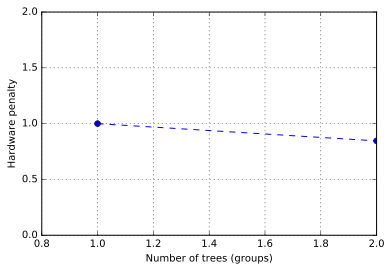

In [35]:
plt.plot(all_g,np.array(all_seconds_per_batch)/all_seconds_per_batch[0],'o--')
plt.grid()
plt.ylabel('Hardware penalty')
plt.axis([None, None, 0, 2]);
plt.xlabel('Number of trees (groups)')

### Statistical efficiency 

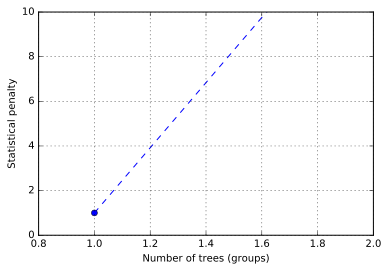

In [37]:
plt.plot(all_g,all_batches_to_target/all_batches_to_target[0], 'o--')
plt.grid()
plt.ylabel('Statistical penalty')
plt.axis([None, None, 0, 10])
plt.xlabel('Number of trees (groups)')

### Efficiency Triplet 

In [38]:
def plot_he(ax):
    ax.plot(all_g,np.array(all_seconds_per_batch)/all_seconds_per_batch[0],'o--')
    ax.grid()
    ax.set_ylabel('Hardware penalty')
    ax.axis([None, None, 0, 2]);
    ax.set_xlabel('# groups')

In [39]:
def plot_se(ax):
    ax.plot(all_g,all_batches_to_target/all_batches_to_target[0], 'o--')
    ax.grid()
    ax.set_ylabel('Statistical penalty')
    ax.axis([None, None, 0, 10])
    ax.set_xlabel('# groups')


In [40]:
def plot_relative_time(ax):
    ax.plot(all_g,np.array(all_seconds_per_batch)*np.array(all_batches_to_target)/(all_batches_to_target[0]*all_seconds_per_batch[0]), 'o--')
    ax.grid()
    ax.set_ylabel('Relative time')
    ax.axis([None, None, 0, 10])
    ax.set_xlabel('# groups')


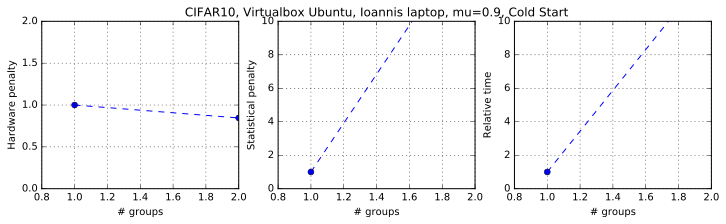

In [41]:
f,ax=plt.subplots(1,3,sharey=False, figsize=(12,3))
plot_he(ax[0])
plot_se(ax[1])
plot_relative_time(ax[2])
ax[1].set_title('CIFAR10, Virtualbox Ubuntu, Ioannis laptop, mu=0.9, Cold Start');

In [33]:
all_seconds_per_batch

[0.3482675034542314, 0.3565352055412371, 0.3978290074647887]

In [45]:
iter0=5000

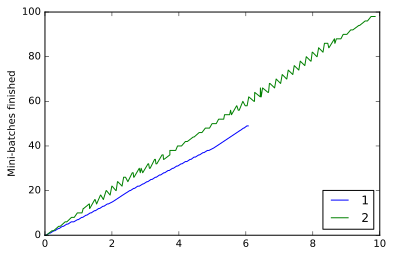

In [46]:
all_iters = []
for gi in range(len(all_g)):
    g = all_g[gi]
    log_file_name = experiment_name+'-n'+str(n)+'-g'+str(g)
    all_lines=load_results(log_file_name)
    iters = [g*(line[2]-iter0) for line in all_lines]
    all_iters.append(iters)
    plt.plot(all_seconds[gi][:200], iters[:200], label=g)
plt.legend(loc='lower right')
plt.ylabel('Mini-batches finished')

In [78]:
all_iters[2][-1]

1775